<a href="https://colab.research.google.com/github/tlqwkrk4471/PytorchBasic/blob/main/Implementing_ViT_in_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.6 MB/s eta 0:00:00


# Implementing ViT in Pytorch
Reference: https://github.com/FrancescoSaverioZuppichini/ViT

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

## Data

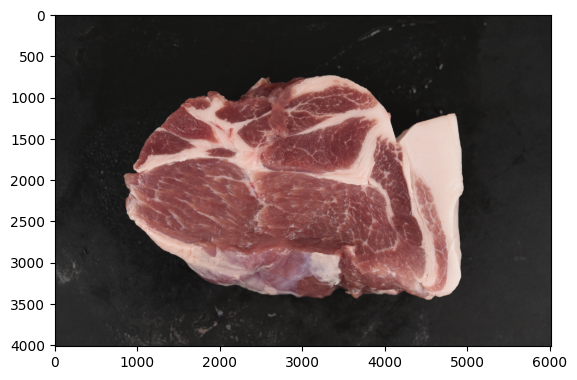

In [18]:
img = Image.open('./meat_data/KakaoTalk_Image_2023-06-13-18-11-22_001.jpeg')

fig = plt.figure()
plt.imshow(img)

In [16]:
img.size

(6016, 4016)

In [57]:
transform = Compose([Resize((4016, 4016)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0)
x.shape

torch.Size([1, 3, 4016, 4016])

## Patches Embedding

2D image → sequence of flattened 2D patches

H x W x C → N x (PPC)

In [62]:
patch_size = 16 # 16 pixels
patches = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)
patches.shape

torch.Size([1, 63001, 768])

In [67]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
    self.patch_size = patch_size
    super().__init__()
    self.projection = nn.Sequential(
      Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
      nn.Linear(patch_size * patch_size * in_channels, emb_size)
    )

  def forward(self, x: Tensor) -> Tensor:
    x = self.projection(x)
    return x

In [78]:
PatchEmbedding()(x).shape

torch.Size([1, 63001, 768])

In [81]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
    self.patch_size = patch_size
    super().__init__()
    self.projection = nn.Sequential(
        nn.Conv2d(in_channels, emb_size, kernel_size = patch_size, stride = patch_size),
        Rearrange('b e h w -> b (h w) e')
    )

  def forward(self, x: Tensor) -> Tensor:
    x = self.projection(x)
    return x

PatchEmbedding()(x).shape

torch.Size([1, 63001, 768])

## CLS Token
shape = (1,1,emb_size)

In [83]:
x.shape

torch.Size([1, 3, 4016, 4016])

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
    self.patch_size = patch_size
    super().__init__()
    self.projection = nn.Sequential(
        nn.Conv2d(in_channels, )
    )